In [244]:
import os
import gzip
import numpy as np
from scipy.stats import pearsonr
from sklearn.cross_decomposition import PLSRegression
from matplotlib import pyplot as plt
import random
import bisect
import math
import json
%matplotlib inline

# Loading the expression data

In [288]:
experiment_data_path = os.path.join("muscle_predictions", "muscle_data")
probeset_IDs_path = os.path.join("muscle_predictions", "muscle_ids")
repeat_length_path = os.path.join("muscle_predictions", "muscle_rt")

In [289]:
with open(probeset_IDs_path) as f:
    probeset_IDs = json.load(f)

with open(repeat_length_path) as f:
    repeat_length = json.load(f)

with open(experiment_data_path) as f:
    probeset_data = np.loadtxt(experiment_data_path)


In [290]:
probeset_data.shape

(60, 27)

# Viewing top correlating genes

While not strictly necessary, and not depended on anywhere else in the pipeline, this allows us to get additional numerical intuition about our data.

In [291]:
correlations = 3

In [292]:
top_correlations = order_indicies(repeat_length, probeset_data)[:correlations]

probeset ID: TNNI1_2450829_GTGCCTTAGTCCGTGCATCCGTGCA_chr1_-_201379335_201379359 r**2: 0.516074133513 Bonf Corr p: 0.00146598405344
probeset ID: TNNI1_2450829_CCCAGGAGAGCCGACTCAAATCAGT_chr1_-_201379303_201379327 r**2: 0.508328146715 Bonf Corr p: 0.00179973215755
probeset ID: TNNI1_2450829_TGCATCCCAGGTGATGTAGACGCTG_chr1_-_201379147_201379171 r**2: 0.474278298315 Bonf Corr p: 0.00428373932358


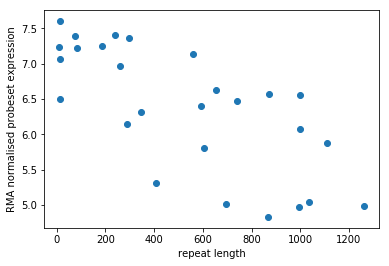

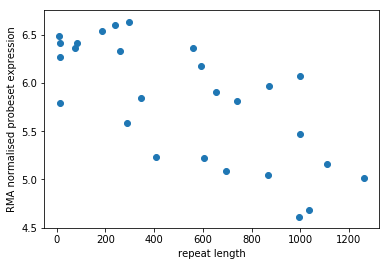

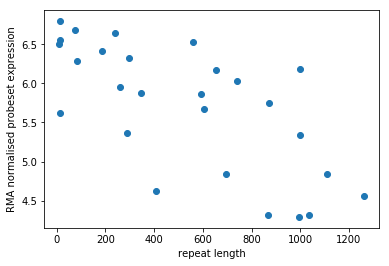

In [293]:
for i in range(correlations):
    f = plt.figure()
    columnI = top_correlations[i][1]
    print("probeset ID:", probeset_IDs[columnI], "r**2:", top_correlations[i][0], "Bonf Corr p:", pearsonr(repeat_length, probeset_data[[columnI], :][0])[1] * probeset_data.shape[0])
    plt.scatter(repeat_length, probeset_data[[columnI], :])
    plt.xlabel("repeat length")
    plt.ylabel("RMA normalised probeset expression")

## Combining defined utility functions into a single `simulation_step` function

Finally, we can wrap all of the examples in this chapter into a single function, which will execute one pass of the simulation (steps 1-4).

In [294]:
def simulation_step(training_size=97, no_probes=500, n_components=10):
    """Execute a full step of the simulation, and return a tuple consisting of two lists:
    predicted repeat lengths, and the ground truth repeat lengths
    """
    training_i, testing_i = choose_training_indicies(probeset_data, training_size)
    training_fold, testing_fold = split_data(probeset_data, training_i, testing_i)
    repeat_length_training = [repeat_length[i] for i in training_i]
    repeat_length_testing = [repeat_length[i] for i in testing_i]
    
    top_500 = order_indicies(repeat_length_training, training_fold)[:no_probes]
    training_set = choose_top_genes(top_500, training_fold)
    testing_set = choose_top_genes(top_500, testing_fold)

    plsr = PLSRegression(n_components=n_components)
    
    plsr.fit(training_set.transpose(), cv(repeat_length_training))
    
    results = plsr.predict(testing_set.transpose())
    results = [i[0] for i in results]

    return repeat_length_testing, results

This is an example of results obtained from a single pass

In [296]:
a, b = simulation_step(training_size=13, no_probes=500, n_components=2)

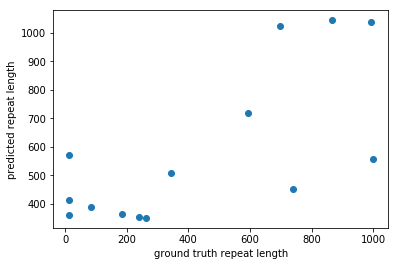

In [297]:
plt.scatter(a, b)
plt.xlabel("ground truth repeat length")
plt.ylabel("predicted repeat length")

# Running the simulation 1000 times to produce the scatter plot of predictions vs ground truth

Equipped with the tools built in the previous chapter we can now execute the final bits of the analysis: running each simulation step 10 thousand times, while recording predicted and ground truth repeat length at each stage.

The authors of the original study carry out this final stage for multiple choice of different parameters. However, they conclude that limiting the analysis to top 500 probesets allows to achieve good predictions.

In [298]:
probeset_data.shape

(60, 27)

In [321]:
real_alleles = []
simulated_alleles = []
for i in range(10):
    real_allele, simulated_allele = simulation_step(training_size=20, no_probes=500, n_components=2)
    real_alleles += real_allele
    simulated_alleles += simulated_allele

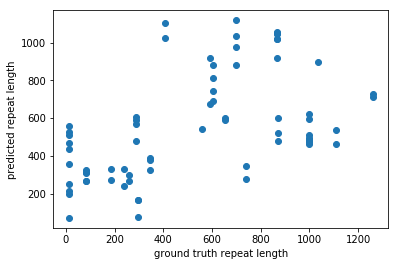

In [322]:
plt.scatter(real_alleles, simulated_alleles)
r, p_value = pearsonr(real_alleles, simulated_alleles)
plt.xlabel("ground truth repeat length")
plt.ylabel("predicted repeat length")

In [323]:
r, p_value = pearsonr(real_alleles, simulated_alleles)

In [324]:
r

0.51463015293536618

As we can see, there is a modest correlation between our predictions and the ground truth, consistent with the findings of the original study.

In [325]:
r**2

0.26484419431027839

## Running a simulation to compute the probability that a random predictor would achieve the same $r^2$ or better (estimating the p-value of null hypothesis that our predictor behaves like a random predictor).

Finally we have to ask how likely it is that a random predictor would achieve $r^2$ as high or higher. We define a random predictor to be a predictor, which samples its output uniformly from our sample's repeat length, without any knowledge of the mRNA profile.

In [304]:
r2s = []
sim = 100000
for i in range(sim):
    repeat_length_random = repeat_length[:]
    random.shuffle(repeat_length_random)
    inter_r, p_value = pearsonr(repeat_length, repeat_length_random)
    r2s.append(inter_r**2)
r2s.sort()

Simulated p-value

In [305]:
print(1 - bisect.bisect_right(r2s, r**2)/float(sim))

0.0007599999999999829
